## Script to integrate cellular immune biomarkers with machine learning to identify potential correlates of protection for a *Trypanosoma cruzi* vaccine

#### **This Python notebook is associated with *Gamba et al.*, "Integrating Cellular Immune Biomarkers with Machine Learning to Identify Potential Correlates of Protection for a *Trypanosoma cruzi* Vaccine."**

The dataset employed in this study is available at [Zenodo](https://doi.org/10.5281/zenodo.16281869) and [GitHub](https://github.com/JuanCruzGamba/PhD_repository/tree/main/publication_projects/integrative_CoP_with_ML).
If you use the code or data provided in this repository, we kindly ask that you cite our work appropriately.

The following main package versions were used to develop this script:<br>
- Python 3.12.1<br>
- NumPy 2.0.2<br>
- Pandas 2.2.3<br>
- Scikit-learn 1.5.2<br>
- Matplotlib 3.9.3<br>

The notebook is divided into 7 sections:
1) **Library imports**: Essential modules and packages required for the notebook's functionalities are loaded here.
2) **Dataset loading and initial visualization**: The raw data is loaded into the environment, followed by initial representations for a first look.
3) **Exploratory analysis**: Exploratory analysis: In-depth examination of the dataset's characteristics, distributions, and relationships between variables.
4) **Rational biomarker engineering and exploratory visualization**: New biomarker are created based on biological rationale, and their initial visual properties are explored.
5) **Evaluation of biomarkers as potential CoPs with ML model**: Machine learning models are applied to assess the performance of the biomarkers as potential Correlates of Protection.
6) **Permutation Tests: Assessing significance between biomarkers and against randomness**: non-parametric statistical tests are performed to evaluate if observed biomarker performance differences are statistically significant or due to chance.
7) **Evaluation of pICoP decision logic under input variability**: The robustness of the potential Integrative Correlate of Protection's decision logic is tested against simulated variations in input data.

This is the 1.0 version.

### 1) Library imports

The necessary libraries are imported below.

In [1]:
# Import required libraries
import math
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

### 2) Dataset loading and initial visualization

The dataset is loaded from an CSV file named `dataset.csv`. To ensure the code runs correctly, ensure `dataset.csv` is located in the same directory as this Jupyter notebook, or in the current working directory from which the notebook is executed. 
The following cell reads the dataset, filters it, and displays the first few rows to inspect its structure and contents.

In [2]:
# Dataset loading and preview
filename = 'dataset.csv'
df = pd.read_csv(filename, header=0)
df.head()

# The dataset is filtered to include only mice from the double_5fu group
df = df[df["group"] == "double_5fu"]

# Select relevant columns 
df_selected = df[['survival_day_25', 'cd8', 'cd4', 'cd11b_gr1']].copy()

### 3) Exploratory analysis

An exploratory analysis is conducted to evaluate whether differences exist in the levels of CD4⁺, CD8⁺, and CD11b⁺ Gr-1⁺ MDSC-like cells in *double 5FU TSf-ISPA* mice, based on their survival status before and after day 25 post-infection (p.i.), which serves as the survival criterion.

To address this, the dataset is first filtered to include only animals from the *double 5FU TSf-ISPA* group, and the relevant immune biomarkers are selected. Scatter plots are then generated to visualize the pairwise relationships among CD8⁺, CD4⁺, and CD11b⁺ Gr-1⁺ cell populations. These plots distinguish between mice that survived and those that died by day 25 p.i., using distinct colors and marker shapes to represent survival status.

This visualization aims to identify potential patterns or differences in immune profiles associated with survival outcomes.

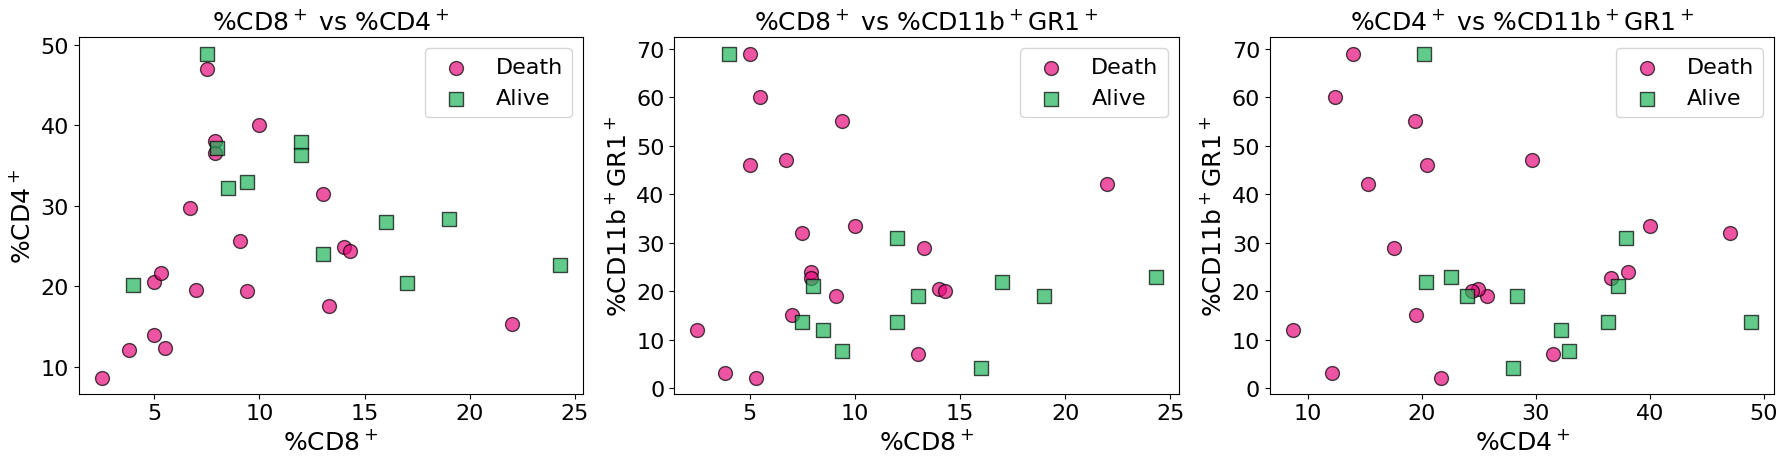

In [3]:
# Dictionary for styles based on survival status at day 25 p.i.
survival_style = {
    0: {"color": "#e60d7d", "marker": "o"},   # Deceased: red circle
    1: {"color": "#1fb458", "marker": "s"}    # Alive: green square
}

# Dictionary for labels
label_map = {
    'cd4': r'%CD4$^+$',
    'cd8': r'%CD8$^+$',
    'cd11b_gr1': r'%CD11b$^+$GR1$^+$'
}

# Generate combinations of pairs of biomarkers for scatter plots
biomarkers = ['cd8', 'cd4', 'cd11b_gr1']
combinations_list = list(combinations(biomarkers, 2))

# Calculate subplot grid dimensions
n_combinations = len(combinations_list)
n_cols = 3
n_rows = math.ceil(n_combinations / n_cols)

# Create figure and axes grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = axes.flatten()

# Plot each biomarker pair
for ax, (x_var, y_var) in zip(axes, combinations_list):
    for survival in df_selected["survival_day_25"].unique():
        subset = df_selected[df_selected["survival_day_25"] == survival]
        style = survival_style.get(survival, {"color": "gray", "marker": "x"})

        ax.scatter(
            subset[x_var],
            subset[y_var],
            color=style["color"],
            marker=style["marker"],
            label=f"{'Death' if survival == 0 else 'Alive'}",
            edgecolors="k",
            alpha=0.7,
            s=100
        )

    ax.set_xlabel(label_map[x_var], fontsize=18)
    ax.set_ylabel(label_map[y_var], fontsize=18)
    ax.set_title(f"{label_map[x_var]} vs {label_map[y_var]}", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    ax.legend(fontsize=16)

# Remove empty subplots if any
for i in range(n_combinations, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and save figure in .tif format
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("scatter_plot_1.tif", dpi=600)
plt.show()

### 4) Rational biomarker engineering and exploratory visualization

Since the initial exploratory analysis based on pairwise scatter plots did not reveal a clear visual separation of survival outcomes among immunized and infected mice, a rational approach was adopted to engineer a new biomarker. This strategy was guided by immunological insights derived from prior studies, which indicated that vaccination with the tested candidate may elicit both effector and suppressive immune responses.

Accordingly, a new feature named **Rational Engineered Biomarker (REB)** was constructed. REB is defined as the sum of peripheral CD8⁺ and CD4⁺ T cell percentages, minus the percentage of CD11b⁺ Gr-1⁺ MDSC-like suppressor cells. This formulation is intended to reflect the balance between protective effector and potentially detrimental suppressive immune populations, and is mathematically expressed as:

$$\text{REB} = \%\,\text{CD8}^+ + \%\,\text{CD4}^+ - \%\,\text{CD11b}^+\,\text{Gr-1}^+$$

The following cell integrates this new biomarker into the dataset and reproduces the exploratory scatter plot analysis, now including the REB variable. Only scatter plots involving REB are displayed, as the goal is to visually inspect whether this engineered combination better separates mice according to their survival status.

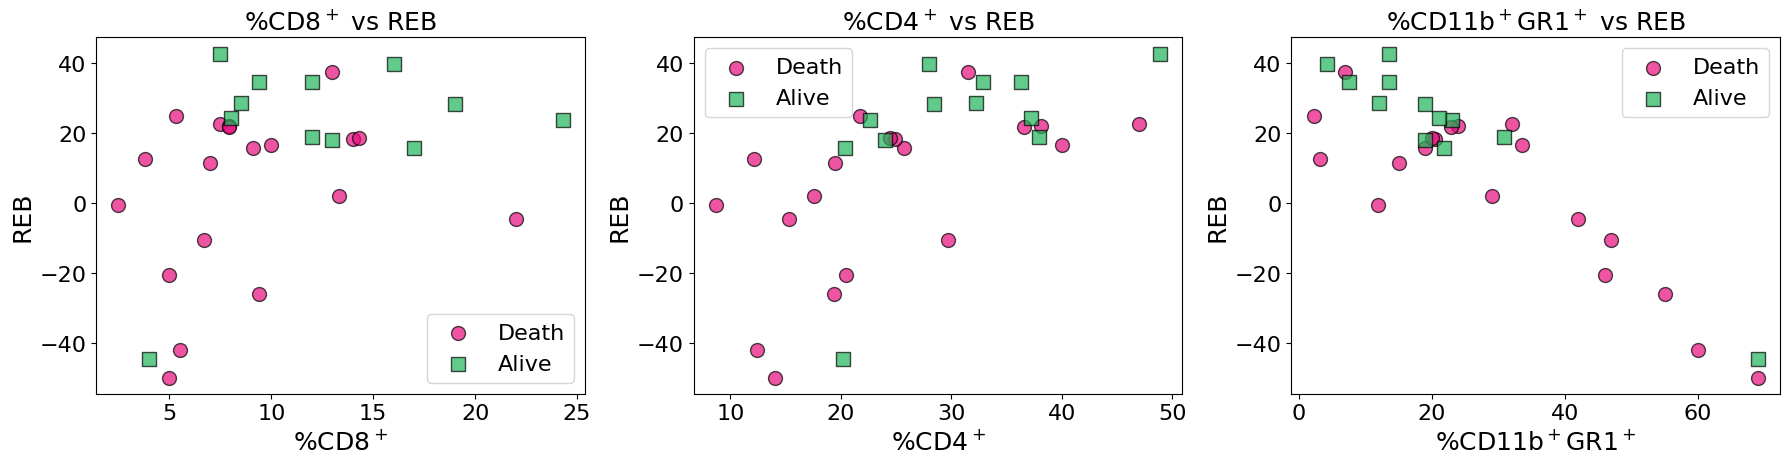

In [4]:
# Calculate the combined biomarker REB using vectorized numpy operations. 
# This creates a new column 'cd8+cd4-cd11b_gr1' in the dataframe as: REB = %CD8+ + %CD4+ - %CD11b+ Gr-1+
df_selected.loc[:, 'cd8+cd4-cd11b_gr1'] = (df_selected['cd8'].to_numpy() +
                                           df_selected['cd4'].to_numpy() -
                                           df_selected['cd11b_gr1'].to_numpy())

# Dictionary for labels
label_map = {
    'cd4': r'%CD4$^+$',
    'cd8': r'%CD8$^+$',
    'cd11b_gr1': r'%CD11b$^+$GR1$^+$',
    'cd8+cd4-cd11b_gr1': r'REB'
}

# Define biomarkers and filter pairs to include the target biomarker 'cd8+cd4-cd11b_gr1'
biomarkers = ['cd8', 'cd4', 'cd11b_gr1', 'cd8+cd4-cd11b_gr1']
target = 'cd8+cd4-cd11b_gr1'

# Generate list of variable pairs where one is the target variable
combinations_list = [(x, y) for x, y in combinations(biomarkers, 2) if target in (x, y)]

# Calculate subplot grid dimensions: number of rows and columns
n_combinations = len(combinations_list)
n_cols = 3
n_rows = math.ceil(n_combinations / n_cols)

# Create figure and axes grid for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = axes.flatten() 

# Plot each pair of biomarkers
for ax, (x_var, y_var) in zip(axes, combinations_list):
    # Iterate over unique survival statuses (0=Death, 1=Alive)
    for survival in df_selected["survival_day_25"].unique():
        subset = df_selected[df_selected["survival_day_25"] == survival]
        style = survival_style.get(survival, {"color": "gray", "marker": "x"})

        ax.scatter(
            subset[x_var],
            subset[y_var],
            color=style["color"],
            marker=style["marker"],
            label=f"{'Death' if survival == 0 else 'Alive'}",
            edgecolors="k",
            alpha=0.7,
            s=100
        )

    # Set axis labels and title with proper formatting
    ax.set_xlabel(label_map[x_var], fontsize=18)
    ax.set_ylabel(label_map[y_var], fontsize=18)
    ax.set_title(f"{label_map[x_var]} vs {label_map[y_var]}", fontsize=18)
    ax.tick_params(axis='both', labelsize=16)
    ax.legend(fontsize=16)

# Remove empty subplots if there are any leftover axes
for i in range(n_combinations, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to avoid overlap and save the figure as a TIF file
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("scatter_plot_2.tif", dpi=600)
plt.show()

### 5) Evaluation of biomarkers as potential CoPs with ML model
This section outlines the process for evaluating individual biomarkers, along with the rational engineered biomarker (REB) and potential integrative CoP (pICoP), as potential CoPs, using a decision tree model. A decision stump (a decision tree with a maximum depth of 1) was employed for this classification task. This model performs a single binary split based on an optimal biomarker threshold to distinguish between survival and death outcomes in treated and challenged mice.

The pICoP (2.0cd8+cd4-cd11b_gr1) analyzed here was identified through a systematic computational search, as detailed in the `pICoP_search.py` script. This search explored all possible weighted linear combinations of %CD8⁺, %CD4⁺, and %CD11b⁺Gr-1⁺ MDSC-like cells within a specified range. Each combination was evaluated using the decision stump model, and the pICoP was selected due to its strong performance (high F1-Score and AUC-ROC), simplicity, and statistical significance as assessed by a permutation test against randomness (p<0.05). This systematic approach further supported the initial rational design by demonstrating the strong influence of CD8⁺ in the most effective combinations.

To assess the model's generalization capability and obtain robust performance estimates, a stratified 5-fold cross-validation procedure was utilized. This method ensures proportional representation of both survival and death classes across all data folds. The cross-validation process was repeated 100 times with different random seeds to enhance the robustness and reliability of the performance metrics, minimizing the impact of any single data split. Performance metrics (such as AUC-ROC, Accuracy, and F1-score) were averaged across all folds and repetitions.

To simplify this notebook, the *BiomarkerDecisionTree* model definition and its detailed internal workings are contained within the `biomarker_decision_tree.py` script. In this notebook, the model is "called" and applied to the corresponding data. Make sure 'biomarker_decision_tree.py' is in the same directory or in a path accessible by Python.

In [5]:
# Import the BiomarkerDecisionTree class from biomarker_decision_tree.py
from biomarker_decision_tree import BiomarkerDecisionTree

# Create an instance of the BiomarkerDecisionTree model.
# It's initialized with 'df_main' as the primary DataFrame and 'survival_day_25' as the target variable for the model.
tree_model = BiomarkerDecisionTree(df_main=df, target_column='survival_day_25')

# Define the feature/biomarker (independent variable) to be used in the decision tree model.
feature = ['2.0cd8+cd4-cd11b_gr1']
# These lines are commented out, but they show other features that could be selected instead.
#feature = ['cd8+cd4-cd11b_gr1']
#feature = ['cd8']
#feature = ['cd4']
#feature = ['cd11b_gr1']

# Set the chosen feature(s) for the 'tree_model' instance.
# This prepares the model with the specific data it needs to work with.
tree_model.set_features_and_target(feature)

# Execute the cross-validation (CV) process for the decision tree model.
# 'num_seeds=100' means the process will be repeated 100 times with different random seeds for robustness.
# 'k_folds=5' indicates that the data will be split into 5 subsets (folds) for validation.
tree_model.run_cross_validation(num_seeds=100, k_folds=5)

# Display the averaged results and their standard deviations calculated from the cross-validation runs.
tree_model.print_results()

# Calculate the confidence intervals for the model's performance metrics.
# 'ci=95' specifies that a 95% confidence interval should be computed.
tree_model.print_confidence_intervals(ci=95)

BiomarkerDecisionTree initialized with the provided DataFrame.
Features set to: ['2.0cd8+cd4-cd11b_gr1'], Target set to: survival_day_25

Starting cross-validation with 100 seeds and 5-fold cross-validation...
Cross-validation completed.

--- Averaged Results ---
Average Confusion Matrix - Training:
[[12.808  2.392]
 [ 0.804  8.796]]

Average Confusion Matrix - Test:
[[3.192 0.608]
 [0.248 2.152]]

Average AUC-ROC Training: 0.88
Average AUC-ROC Test: 0.87

Average Classification Report - Training:
Class 0 --- Precision: 0.94, Recall: 0.84, F1: 0.89
Class 1 --- Precision: 0.79, Recall: 0.92, F1: 0.85
Accuracy: 0.87

Average Classification Report - Test:
Class 0 --- Precision: 0.94, Recall: 0.84, F1: 0.87
Class 1 --- Precision: 0.80, Recall: 0.90, F1: 0.83
Accuracy: 0.86

--- Metric Standard Deviations (across seeds) ---

AUC-ROC STD Training: 0.00
AUC-ROC STD Test: 0.03

Standard Deviation - Training:
Class 0 --- Precision: 0.00, Recall: 0.00, F1: 0.00
Class 1 --- Precision: 0.00, Recal

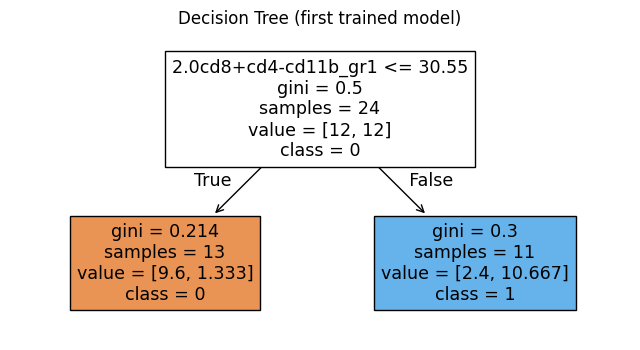

Decision Tree plot saved as 'decision_tree.tif'


In [6]:
# Generate and display a visual representation (plot) of the first decision tree
# that was built during the cross-validation process. This helps in understanding the decision rules learned by the model.
tree_model.plot_first_decision_tree()


Average decision threshold (cutoff line): 30.5656 ± 0.3106
Cutoff (threshold) CI95%: [30.5425, 30.5962]


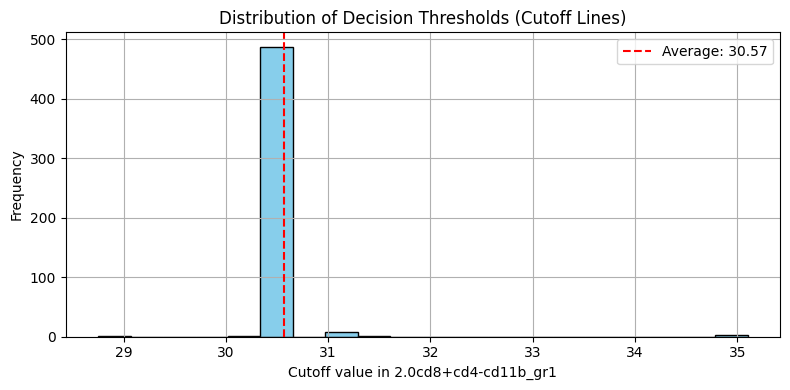

Threshold distribution plot displayed.


In [7]:
# Perform an analysis to understand the distribution of the decision thresholds identified by the model across all the cross-validation runs. 
tree_model.analyze_thresholds()

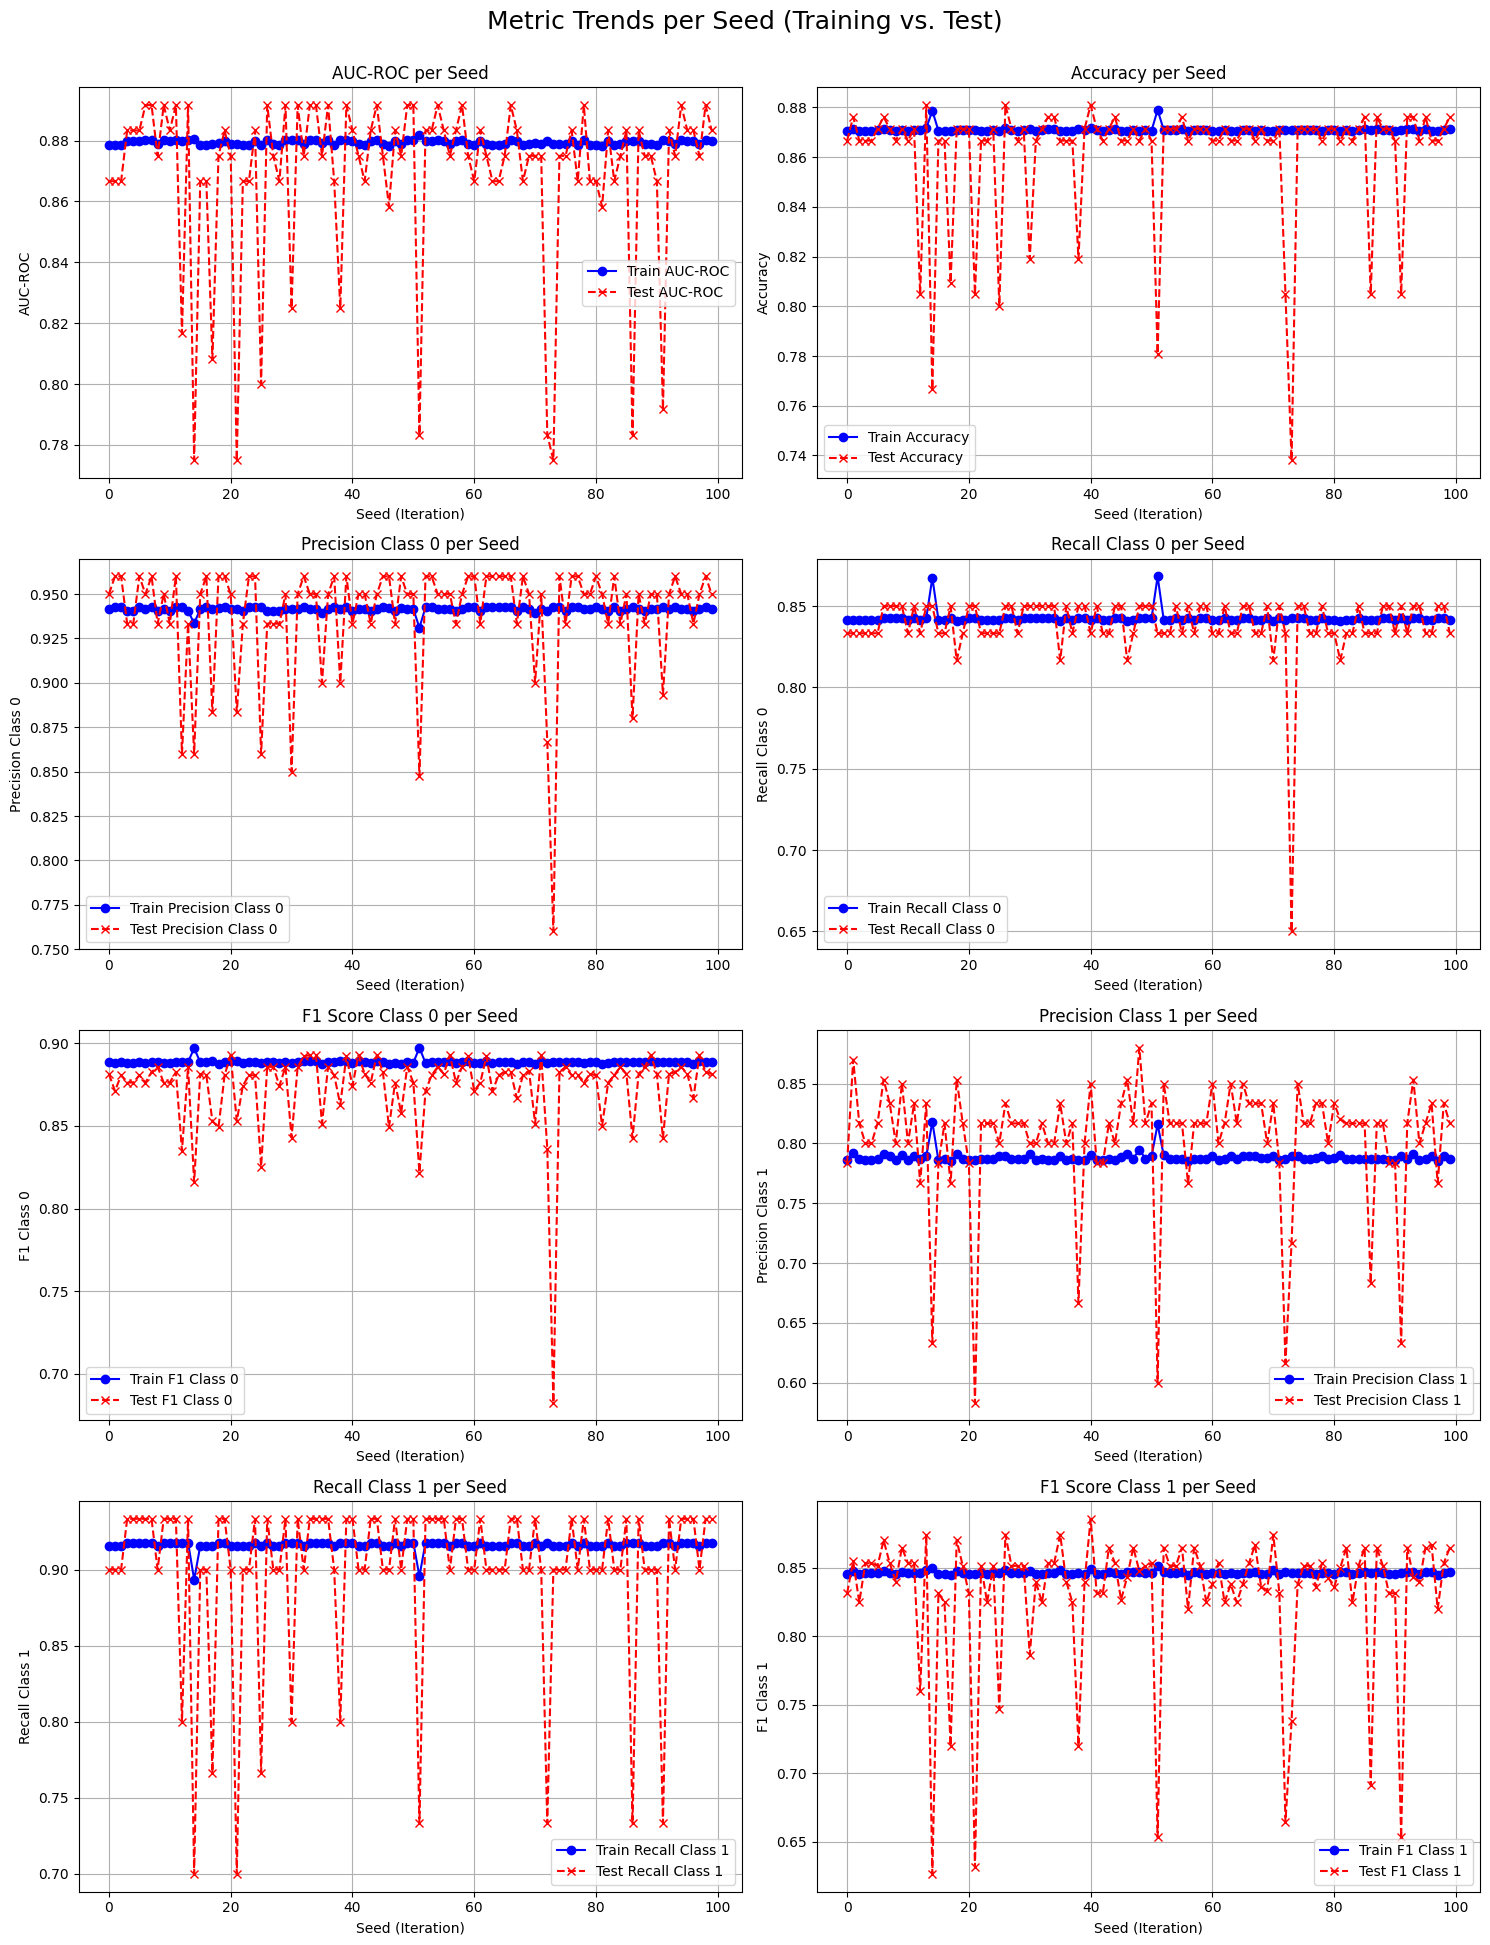

Metric trend plots displayed in a 4x2 grid and saved as 'metric_trends_grid.tif'.


In [8]:
# Generate plots that show the trends of various performance metrics across the different cross-validation seeds.
# This helps visualize how stable the model's performance is.
tree_model.plot_metric_trends()

### 6) Permutation Tests: assessing significance between biomarkers and against randomness
This section uses permutation tests—powerful, non-parametric methods robust against non-Gaussian data—to rigorously evaluate biomarker performance.
1. **Two-Group Mean-Difference Permutation Test (Between Biomarkers)**.
This test compares performance metrics (e.g., AUC-ROC, accuracy, F1-score) between two different biomarkers or models. It effectively tests the null hypothesis that any observed difference in mean performance between the two groups is solely due to chance.

    The process involves:

    - The observed difference in the mean performance metrics between the two biomarkers being calculated from the original data.
    - A null distribution of differences then being generated by randomly shuffling the group labels (indicating which biomarker the performance score belongs to). For each shuffle, the mean difference between the two (now randomized) groups is re-      
    calculated.
    - A p-value being derived empirically by finding the fraction of permuted differences whose absolute value is at least as large as the absolute value of the observed difference. This "two-sided" approach accounts for differences in either direction
    (Biomarker A being better than B, or B being better than A).

2. **Permutation Test Against Randomness (vs. Chance)**
This test determines if a model's performance could have occurred purely by chance.

    The process involves:

    - An observed statistic (like AUC-ROC) first being computed from the original, unpermuted data. This represents the actual performance of the biomarker model.
    - A null distribution then being generated by repeatedly permuting the sample labels (or target values) randomly. For each permutation, the model is re-evaluated with these shuffled labels, and the test statistic is re-calculated. This creates an 
    empirical null distribution, showing what performance looks like under random conditions.
    - A p-value being derived as the proportion of permutations that yield a test statistic as extreme or more extreme than the observed one. A low p-value suggests the observed performance is unlikely due to chance.

##### Two-Group Mean-Difference Permutation Test


===== MÉTRICA: AUC =====
BiomarkerDecisionTree initialized with the provided DataFrame.
Features set to: ['cd8+cd4-cd11b_gr1'], Target set to: survival_day_25

Starting cross-validation with 100 seeds and 5-fold cross-validation...
Cross-validation completed.
BiomarkerDecisionTree initialized with the provided DataFrame.
Features set to: ['2.0cd8+cd4-cd11b_gr1'], Target set to: survival_day_25

Starting cross-validation with 100 seeds and 5-fold cross-validation...
Cross-validation completed.

AUC average (cd8+cd4-cd11b_gr1): 0.6973
AUC average (2.0cd8+cd4-cd11b_gr1): 0.8689
Observed difference (auc combined - cd8): 0.1716
95% CI: (-0.0361, 0.0367)
P-value (two-sided permutation test): 0.0000

Conclusion: Significant difference. The feature '2.0cd8+cd4-cd11b_gr1' is significantly better.


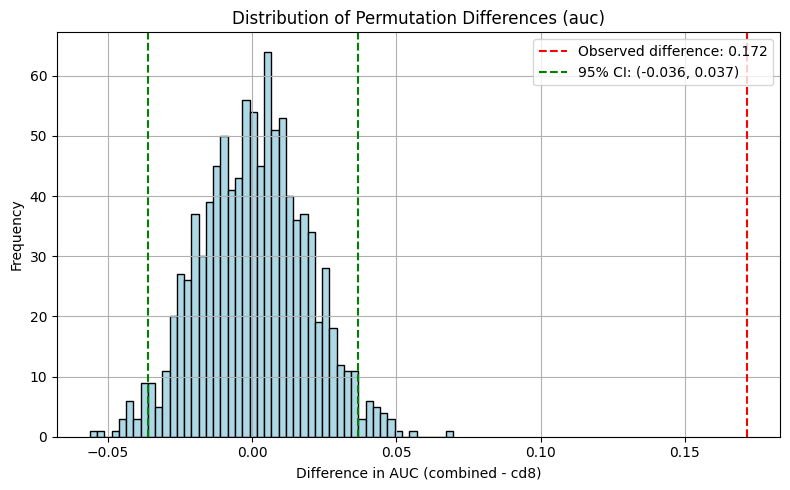


===== MÉTRICA: ACCURACY =====
BiomarkerDecisionTree initialized with the provided DataFrame.
Features set to: ['cd8+cd4-cd11b_gr1'], Target set to: survival_day_25

Starting cross-validation with 100 seeds and 5-fold cross-validation...
Cross-validation completed.
BiomarkerDecisionTree initialized with the provided DataFrame.
Features set to: ['2.0cd8+cd4-cd11b_gr1'], Target set to: survival_day_25

Starting cross-validation with 100 seeds and 5-fold cross-validation...
Cross-validation completed.

ACCURACY average (cd8+cd4-cd11b_gr1): 0.7161
ACCURACY average (2.0cd8+cd4-cd11b_gr1): 0.8616
Observed difference (accuracy combined - cd8): 0.1455
95% CI: (-0.0307, 0.0304)
P-value (two-sided permutation test): 0.0000

Conclusion: Significant difference. The feature '2.0cd8+cd4-cd11b_gr1' is significantly better.


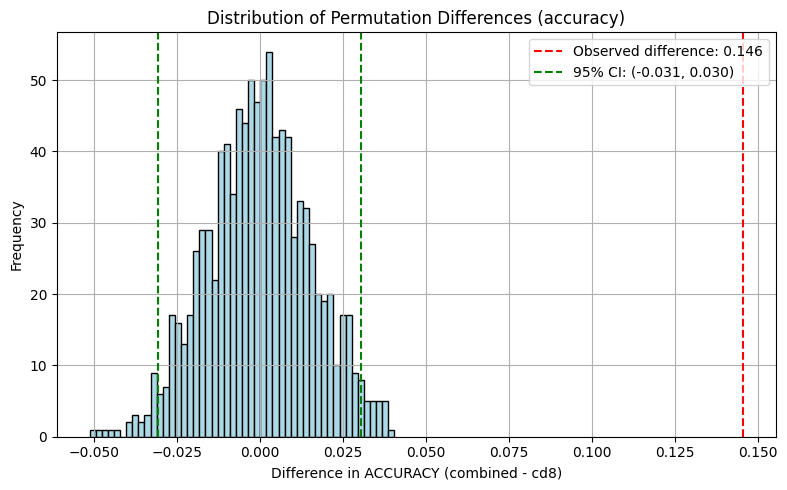


===== MÉTRICA: F1 =====
BiomarkerDecisionTree initialized with the provided DataFrame.
Features set to: ['cd8+cd4-cd11b_gr1'], Target set to: survival_day_25

Starting cross-validation with 100 seeds and 5-fold cross-validation...
Cross-validation completed.
BiomarkerDecisionTree initialized with the provided DataFrame.
Features set to: ['2.0cd8+cd4-cd11b_gr1'], Target set to: survival_day_25

Starting cross-validation with 100 seeds and 5-fold cross-validation...
Cross-validation completed.

F1 average (cd8+cd4-cd11b_gr1): 0.6094
F1 average (2.0cd8+cd4-cd11b_gr1): 0.8301
Observed difference (f1 combined - cd8): 0.2207
95% CI: (-0.0470, 0.0426)
P-value (two-sided permutation test): 0.0000

Conclusion: Significant difference. The feature '2.0cd8+cd4-cd11b_gr1' is significantly better.


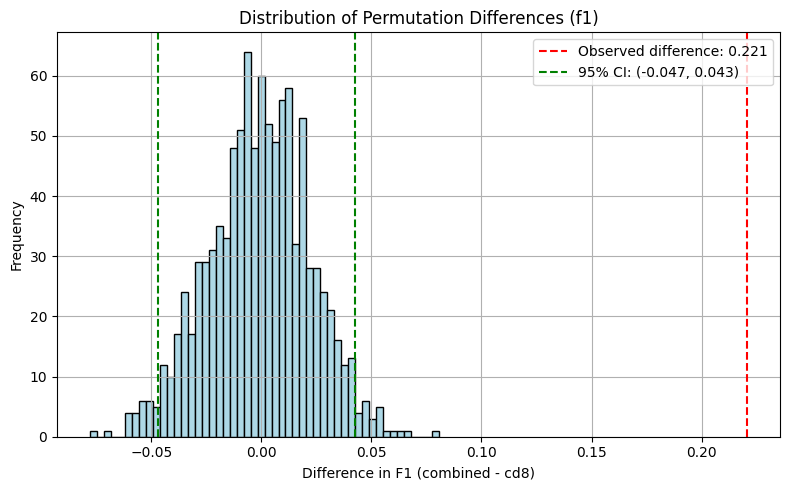

In [9]:
# Definition of both biomarkers for evaluation
feature_set_cd8 = ["cd8+cd4-cd11b_gr1"]
feature_set_comb = ["2.0cd8+cd4-cd11b_gr1"]

# Function to run cross-validation and obtain metrics from the model
def run_cv_metric(df_data, features, target_col, metric, num_seeds=100, k_folds=5):
    """
    Runs cross-validation using the BiomarkerDecisionTree class
    and returns the average scores per seed for the specified metric.

    Args:
        df_data (pd.DataFrame): The main DataFrame with all columns.
        features (list): List of column names to use as features.
        target_col (str): Name of the target column.
        metric (str): The metric to return ('auc', 'accuracy', 'f1').
        num_seeds (int): Number of cross-validation repetitions with different seeds.
        k_folds (int): Number of folds for cross-validation.

    Returns:
        np.array: An array of scores, where each score is the average of the k_folds
                  for a specific seed.
    """
    # Instantiate the BiomarkerDecisionTree model
    # The BiomarkerDecisionTree constructor takes the complete DataFrame and the target column name.
    bdt_model = BiomarkerDecisionTree(df_main=df_data, target_column=target_col)

    # Set the features for the model
    bdt_model.set_features_and_target(features)

    # Execute cross-validation using the internal method of BiomarkerDecisionTree
    # This method will handle the seed and K-Fold loops.
    bdt_model.run_cross_validation(num_seeds=num_seeds, k_folds=k_folds)

    # Get the seed-averaged results for the desired metric
    # The `get_seed_averaged_metric_scores` method must return an array of size `num_seeds`, where each element is the average of the k_folds for that particular seed.
    scores_per_seed = bdt_model.get_seed_averaged_metric_scores(metric)
    
    return scores_per_seed

# Function to perform the permutation test
def permutation_test(metric1, metric2, n_permutations=1000):
    """
    Performs a two-sided permutation test to compare two sets of metrics.

    Args:
        metric1 (np.array): Array of scores for the first model/feature.
        metric2 (np.array): Array of scores for the second model/feature.
        n_permutations (int): Number of permutations to perform.

    Returns:
        tuple: (observed_diff, p_value, ci_low, ci_high, diffs_distribution)
    """
    observed_diff = np.mean(metric2) - np.mean(metric1)
    # Combine the results and transpose them to facilitate permutation
    combined = np.vstack([metric1, metric2]).T
    diffs = []
    for _ in range(n_permutations):
        # Create a random mask to permute the labels
        mask = np.random.rand(len(combined)) < 0.5
        # Apply the permutation: if mask is True, maintain order; if False, invert it
        perm1 = np.where(mask, combined[:, 0], combined[:, 1])
        perm2 = np.where(mask, combined[:, 1], combined[:, 0])
        diffs.append(np.mean(perm2) - np.mean(perm1))
    diffs = np.array(diffs)
    # Calculate the p-value (proportion of permuted differences as extreme or more extreme than the observed)
    p_value = np.mean(np.abs(diffs) >= np.abs(observed_diff))
    # Calculate the 95% confidence interval for the distribution of permuted differences
    ci_low, ci_high = np.percentile(diffs, [2.5, 97.5])
    return observed_diff, p_value, ci_low, ci_high, diffs

# Main function to run the analysis per metric
def run_analysis(metric_name, df):
    print(f"\n===== MÉTRICA: {metric_name.upper()} =====")
    
    # Prepare the data for each feature set
    # The run_cv_metric function now receives the complete DataFrame 'df', the features, and the target column name
    target_column_name = 'survival_day_25'

    # Run cross-validation for both feature sets
    scores_cd8 = run_cv_metric(df, feature_set_cd8, target_column_name, metric=metric_name)
    scores_comb = run_cv_metric(df, feature_set_comb, target_column_name, metric=metric_name)

    # Perform the permutation test to compare the results
    observed_diff, p_value, ci_low, ci_high, diffs = permutation_test(scores_cd8, scores_comb)

    # Print the results
    print(f"\n{metric_name.upper()} average (cd8+cd4-cd11b_gr1): {np.mean(scores_cd8):.4f}")
    print(f"{metric_name.upper()} average (2.0cd8+cd4-cd11b_gr1): {np.mean(scores_comb):.4f}")
    print(f"Observed difference ({metric_name} combined - cd8): {observed_diff:.4f}")
    print(f"95% CI: ({ci_low:.4f}, {ci_high:.4f})")
    print(f"P-value (two-sided permutation test): {p_value:.4f}")

    # Conclusion based on the p-value
    if p_value < 0.05:
        better_feature = "2.0cd8+cd4-cd11b_gr1" if observed_diff > 0 else "cd8+cd4-cd11b_gr1"
        print(f"\nConclusion: Significant difference. The feature '{better_feature}' is significantly better.")
    else:
        print("\nConclusion: No significant difference between the evaluated features.")

    # Visualization of the permutation differences distribution
    plt.figure(figsize=(8, 5))
    plt.hist(diffs, bins=50, color='lightblue', edgecolor='black')
    plt.axvline(observed_diff, color='red', linestyle='--', label=f'Observed difference: {observed_diff:.3f}')
    plt.axvline(ci_low, color='green', linestyle='--', label=f'95% CI: ({ci_low:.3f}, {ci_high:.3f})')
    plt.axvline(ci_high, color='green', linestyle='--')
    plt.title(f'Distribution of Permutation Differences ({metric_name})')
    plt.xlabel(f'Difference in {metric_name.upper()} (combined - cd8)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# To run the analysis, we explicitly pass 'df' to `run_analysis`
for metric in ['auc', 'accuracy', 'f1']:
    run_analysis(metric, df)

##### Permutation Test Against Randomness


===== PERMUTATION TEST AGAINST RANDOMNESS: METRIC AUC =====
Calculating observed score for 'auc' with 100 seeds and 5 folds...
BiomarkerDecisionTree initialized with the provided DataFrame.
Features set to: ['2.0cd8+cd4-cd11b_gr1'], Target set to: survival_day_25

Starting cross-validation with 100 seeds and 5-fold cross-validation...
Cross-validation completed.
Average observed score (auc): 0.8689 (STD: 0.0294)
Generating null distribution with 1000 label permutations...
  Completed 100/1000 permutations...
  Completed 200/1000 permutations...
  Completed 300/1000 permutations...
  Completed 400/1000 permutations...
  Completed 500/1000 permutations...
  Completed 600/1000 permutations...
  Completed 700/1000 permutations...
  Completed 800/1000 permutations...
  Completed 900/1000 permutations...
  Completed 1000/1000 permutations...

--- Permutation Test Results ---
Average observed score (auc): 0.8689
P-value (one-tailed permutation test, 'better than chance'): 0.0000

Conclusion:

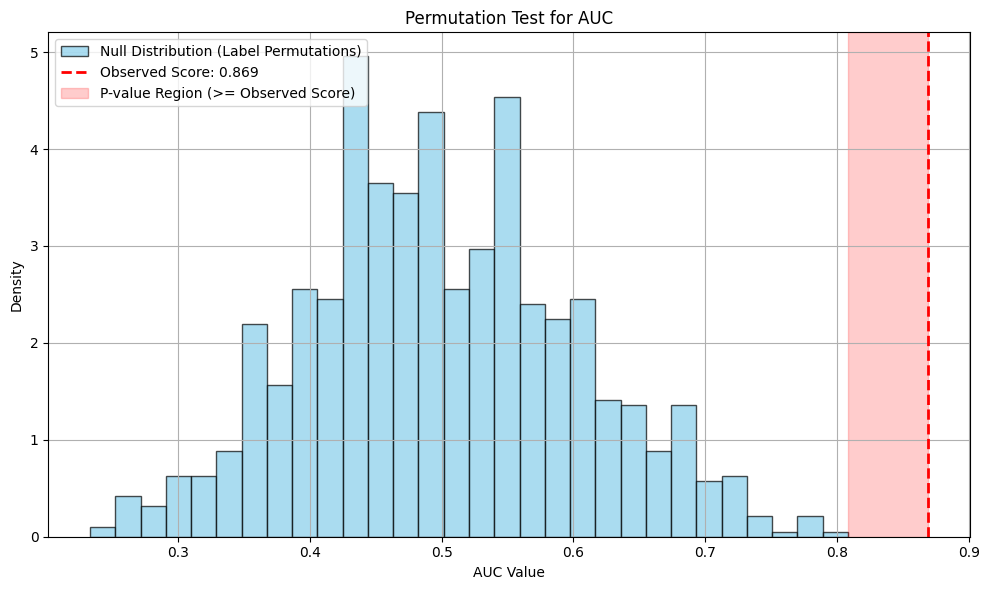

Null distribution plot for AUC shown.

===== PERMUTATION TEST AGAINST RANDOMNESS: METRIC ACCURACY =====
Calculating observed score for 'accuracy' with 100 seeds and 5 folds...
BiomarkerDecisionTree initialized with the provided DataFrame.
Features set to: ['2.0cd8+cd4-cd11b_gr1'], Target set to: survival_day_25

Starting cross-validation with 100 seeds and 5-fold cross-validation...
Cross-validation completed.
Average observed score (accuracy): 0.8616 (STD: 0.0256)
Generating null distribution with 1000 label permutations...
  Completed 100/1000 permutations...
  Completed 200/1000 permutations...
  Completed 300/1000 permutations...
  Completed 400/1000 permutations...
  Completed 500/1000 permutations...
  Completed 600/1000 permutations...
  Completed 700/1000 permutations...
  Completed 800/1000 permutations...
  Completed 900/1000 permutations...
  Completed 1000/1000 permutations...

--- Permutation Test Results ---
Average observed score (accuracy): 0.8616
P-value (one-tailed pe

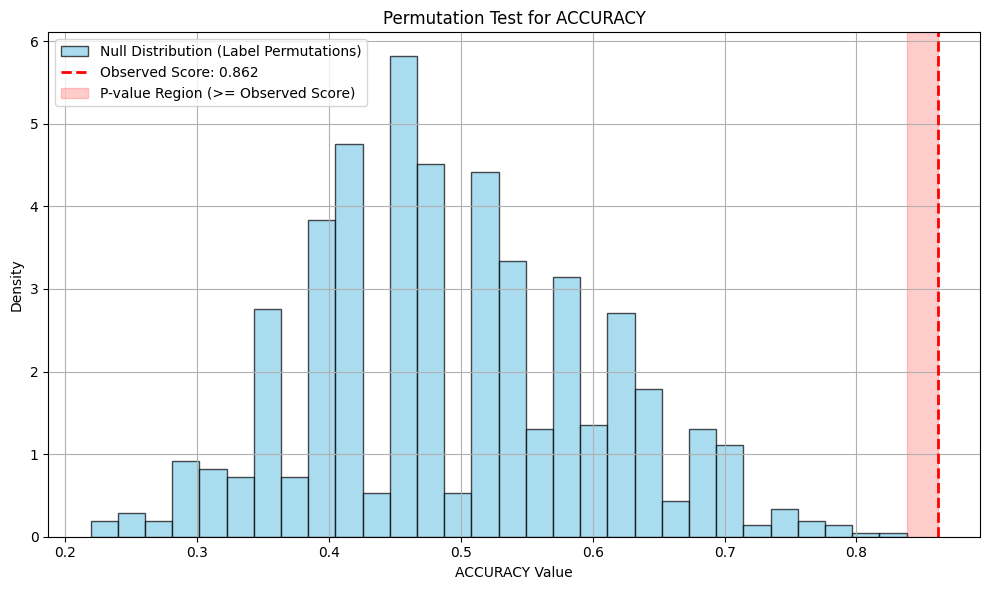

Null distribution plot for ACCURACY shown.

===== PERMUTATION TEST AGAINST RANDOMNESS: METRIC F1 =====
Calculating observed score for 'f1' with 100 seeds and 5 folds...
BiomarkerDecisionTree initialized with the provided DataFrame.
Features set to: ['2.0cd8+cd4-cd11b_gr1'], Target set to: survival_day_25

Starting cross-validation with 100 seeds and 5-fold cross-validation...
Cross-validation completed.
Average observed score (f1): 0.8301 (STD: 0.0533)
Generating null distribution with 1000 label permutations...
  Completed 100/1000 permutations...
  Completed 200/1000 permutations...
  Completed 300/1000 permutations...
  Completed 400/1000 permutations...
  Completed 500/1000 permutations...
  Completed 600/1000 permutations...
  Completed 700/1000 permutations...
  Completed 800/1000 permutations...
  Completed 900/1000 permutations...
  Completed 1000/1000 permutations...

--- Permutation Test Results ---
Average observed score (f1): 0.8301
P-value (one-tailed permutation test, 'be

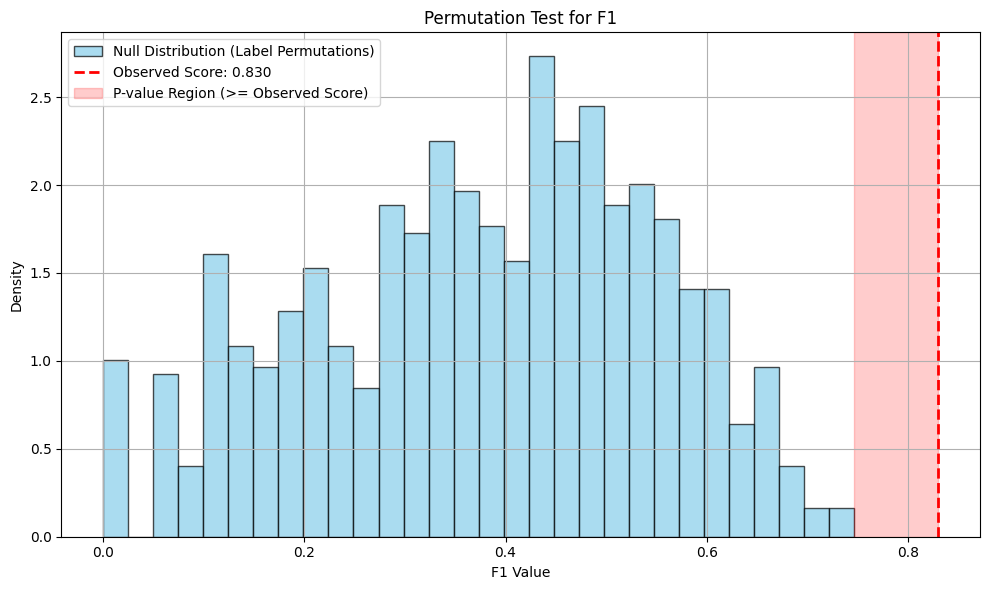

Null distribution plot for F1 shown.


In [10]:
# Definition of Feature Sets 
feature_set_comb = ["2.0cd8+cd4-cd11b_gr1"]
target_column_name = 'survival_day_25' 

# Function to run cross-validation and obtain metrics 
def run_cv_metric(df_data, features, target_col, metric, num_seeds=100, k_folds=5):
    """
    Runs cross-validation using the BiomarkerDecisionTree class
    and returns the average scores per seed for the specified metric.

    Args:
        df_data (pd.DataFrame): The main DataFrame with all columns.
        features (list): List of column names to use as features.
        target_col (str): Name of the target column.
        metric (str): The metric to return ('auc', 'accuracy', 'f1').
        num_seeds (int): Number of cross-validation repetitions with different seeds.
        k_folds (int): Number of folds for cross-validation.

    Returns:
        np.array: An array of scores, where each score is the average of the k_folds
                  for a specific seed.
    """
    # Instantiate the BiomarkerDecisionTree model
    bdt_model = BiomarkerDecisionTree(df_main=df_data, target_column=target_col)

    # Set the features for the model
    bdt_model.set_features_and_target(features)

    # Execute cross-validation using BiomarkerDecisionTree's internal method
    bdt_model.run_cross_validation(num_seeds=num_seeds, k_folds=k_folds, max_depth=1)
                                                                            
    # Get the seed-averaged results for the desired metric
    scores_per_seed = bdt_model.get_seed_averaged_metric_scores(metric)
    
    return scores_per_seed

# Helper function to get a metric for a single permuted dataset
def _perform_single_permutation_run(df_input, features, target_col, metric_name, seed, k_folds=5):
    """
    Trains and evaluates a Decision Tree model with max_depth=1
    on a single permutation of the data (or the original data).
    Uses StratifiedKFold for internal CV for each permutation.

    Args:
        df_input (pd.DataFrame): The DataFrame with data for this run.
                                  Can be the original df or a version with a permuted target.
        features (list): List of column names for X.
        target_col (str): Name of the target column.
        metric_name (str): Metric to calculate ('auc', 'accuracy', 'f1').
        seed (int): Seed for StratifiedKFold.
        k_folds (int): Number of folds for StratifiedKFold.

    Returns:
        float: The average metric score across the k_folds for this run.
    """
    X_data = df_input[features]
    y_data = df_input[target_col]

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)
    fold_scores = []

    for train_index, test_index in skf.split(X_data, y_data):
        X_train, X_test = X_data.iloc[train_index], X_data.iloc[test_index]
        y_train, y_test = y_data.iloc[train_index], y_data.iloc[test_index]

        # Use the DecisionTreeClassifier model directly for this helper
        clf = DecisionTreeClassifier(max_depth=1, class_weight='balanced', random_state=seed)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1] # For AUC

        if metric_name == 'auc':
            score = roc_auc_score(y_test, y_prob)
        elif metric_name == 'accuracy':
            score = accuracy_score(y_test, y_pred)
        elif metric_name == 'f1':
            score = f1_score(y_test, y_pred, pos_label=1) # Assumes '1' is the positive class
        else:
            raise ValueError(f"Unsupported metric: {metric_name}")
        
        fold_scores.append(score)
    
    return np.mean(fold_scores)

# Main function to run the analysis per metric (includes permutation test)
def run_analysis_with_permutation_test(metric_name, df, num_permutations=1000, num_seeds_cv=100, k_folds_cv=5):
    """
    Runs the complete analysis for a metric, including observed score calculation
    and a permutation test against randomness for the 'feature_set_comb' feature.

    Args:
        metric_name (str): The metric to evaluate ('auc', 'accuracy', 'f1').
        df (pd.DataFrame): The main DataFrame with the data (consistently named 'df').
        num_permutations (int): Number of permutations for the significance test.
        num_seeds_cv (int): Number of seeds for the observed score's CV.
        k_folds_cv (int): Number of folds for the observed score's CV.
    """
    print(f"\n===== PERMUTATION TEST AGAINST RANDOMNESS: METRIC {metric_name.upper()} =====")
    
    # Calculate the observed model score with original data
    print(f"Calculating observed score for '{metric_name}' with {num_seeds_cv} seeds and {k_folds_cv} folds...")
    observed_scores_per_seed = run_cv_metric(df, feature_set_comb, target_column_name, metric=metric_name,
                                             num_seeds=num_seeds_cv, k_folds=k_folds_cv)
    
    observed_mean_score = np.mean(observed_scores_per_seed)
    observed_std_score = np.std(observed_scores_per_seed)
    
    print(f"Average observed score ({metric_name}): {observed_mean_score:.4f} (STD: {observed_std_score:.4f})")

    # 2. Generate the null distribution using permutations
    print(f"Generating null distribution with {num_permutations} label permutations...")
    null_distribution_scores = []
    
    # Create a copy of the DataFrame to permute labels without affecting the original
    df_perm = df.copy()

    for i in range(num_permutations):
        # Randomly permute the target labels
        permuted_y = df_perm[target_column_name].sample(frac=1, random_state=i, replace=False).reset_index(drop=True)
        
        # Create a temporary DataFrame with original X and permuted y
        df_temp = df_perm.copy()
        df_temp[target_column_name] = permuted_y # Assign the permuted labels

        # Train and evaluate the model with permuted data
        score_on_permuted_data = _perform_single_permutation_run(
            df_temp, feature_set_comb, target_column_name, metric_name, seed=i, k_folds=k_folds_cv
        )
        null_distribution_scores.append(score_on_permuted_data)
        
        # Print progress
        if (i + 1) % (num_permutations / 10) == 0:
            print(f"  Completed {i+1}/{num_permutations} permutations...")

    null_distribution_scores = np.array(null_distribution_scores)
    
    # Calculate the p-value (one-tailed test, "is better than chance")
    p_value = np.mean(null_distribution_scores >= observed_mean_score)
    
    print(f"\n--- Permutation Test Results ---")
    print(f"Average observed score ({metric_name}): {observed_mean_score:.4f}")
    print(f"P-value (one-tailed permutation test, 'better than chance'): {p_value:.4f}")

    # Conclusion based on the p-value
    alpha = 0.05
    if p_value < alpha:
        print(f"\nConclusion: Model performance ({metric_name}={observed_mean_score:.4f}) is significantly BETTER than expected by chance (p={p_value:.4f} < {alpha}).")
    else:
        print(f"\nConclusion: There is not enough evidence to state that model performance ({metric_name}={observed_mean_score:.4f}) is significantly better than expected by chance (p={p_value:.4f} >= {alpha}).")

    # Visualization of the null distribution
    plt.figure(figsize=(10, 6))
    plt.hist(null_distribution_scores, bins=30, color='skyblue', edgecolor='black', density=True, alpha=0.7,
             label='Null Distribution (Label Permutations)')
    plt.axvline(observed_mean_score, color='red', linestyle='--', linewidth=2,
                label=f'Observed Score: {observed_mean_score:.3f}')
    
    plt.axvspan(observed_mean_score, null_distribution_scores.max(), color='red', alpha=0.2, label='P-value Region (>= Observed Score)')

    plt.title(f'Permutation Test for {metric_name.upper()}')
    plt.xlabel(f'{metric_name.upper()} Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print(f"Null distribution plot for {metric_name.upper()} shown.")

# To run the analysis, we explicitly pass 'df' to `run_analysis_with_permutation_test`
for metric in ['auc', 'accuracy', 'f1']:
    run_analysis_with_permutation_test(metric, df)

### 7) Evaluation of pICoP decision logic under input variability
This analysis simulates input variability to assess the robustness of a potential Integrative Correlate of Protection (pICoP) decision logic. The goal is to determine if the classification model, derived from a linear combination of flow cytometry measurements (%CD4⁺, %CD8⁺, %CD11b⁺ Gr-1⁺ MDSC-like cells), maintains its effectiveness when applied to perturbed data.

Random stochastic noise is systematically introduced into the original measurements across three predefined ranges: ±0-5%, ±5-10%, and ±10-15% of their original values. For each level of variability, a new dataset is generated, and the pICoP is recalculated using its defined linear combination. A new decision tree model (a single stump, max_depth=1) is then trained and evaluated on each perturbed dataset, with kfold=5. This entire process is repeated 100 times for every variability condition to generate a robust set of performance metrics.

The Area Under the ROC Curve (AUC-ROC) serves as the primary performance metric. To quantify the model's stability, the number of iterations where the AUC-ROC exceeds a threshold of 0.7 (indicating acceptable discriminatory performance) is recorded for each variability level.

Count of AUC > 0.7 per variability condition:
No variability: 100 / 100
±0–5%: 76 / 100
±5–10%: 70 / 100
±10–15%: 63 / 100


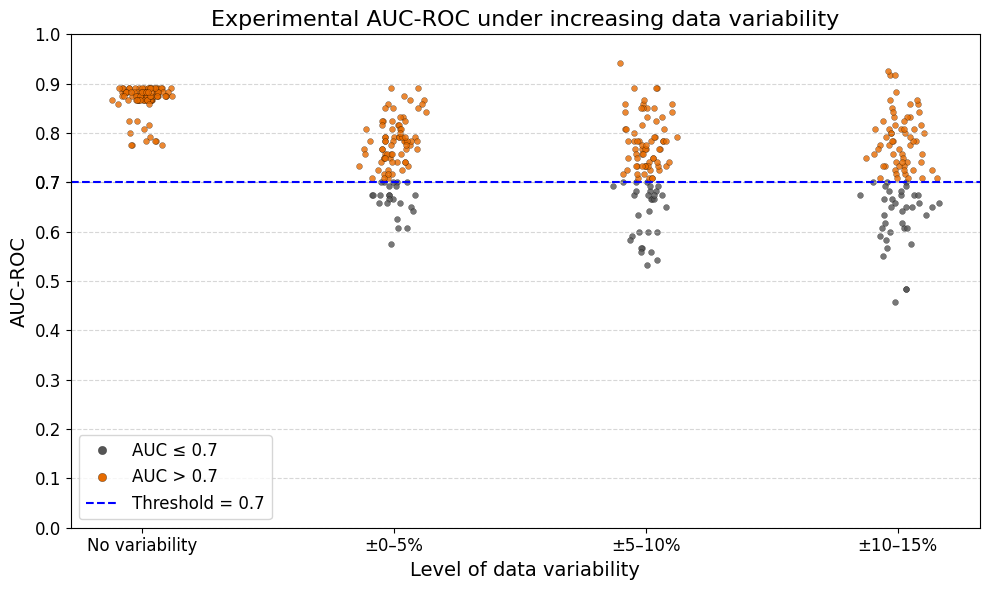

In [11]:
# Feature Set Definition
# Original flow cytometry variables to which noise will be applied
features_to_vary = ["cd8", "cd4", "cd11b_gr1"] 
# Ranges of stochastic variability to be introduced (e.g., (-0.05, 0.05) for ±5%)
noise_ranges = [(0, 0), (-0.05, 0.05), (-0.1, 0.1), (-0.15, 0.15)]
# Labels for each variability condition, used for plotting
variability_labels = ["No variability", "±0–5%", "±5–10%", "±10–15%"]

# Simulation parameters
num_iterations_per_condition = 100 # Number of independent trials for each variability level
num_cv_folds = 5                   # Number of folds for internal cross-validation
auc_threshold = 0.7                # AUC-ROC threshold for acceptable performance

# Target column name in the DataFrame
target_column_name = "survival_day_25"

# List to store AUC-ROC results for all variability conditions
# Each element will be a list of 100 AUC scores (one for each iteration under that variability)
all_auc_scores_per_variability = []

# Main Simulation Loop
# Iterates through each defined variability range
for i, current_noise_range in enumerate(noise_ranges):
    # List to store AUC-ROC scores for the current variability condition across all iterations
    auc_scores_for_current_variability = []

    # Inner loop: repeats the process 'num_iterations_per_condition' times for each variability level
    for iteration_seed in range(num_iterations_per_condition):
        # Apply Variability to Input Data
        # If no variability, use original data copy; otherwise, add noise
        if current_noise_range == (0, 0):
            varied_data = df.copy()
        else:
            # Set random seed for reproducible noise generation for each iteration
            np.random.seed(iteration_seed + 1000 * i) 
            varied_data = df.copy()
            for feature in features_to_vary:
                # Generate uniform random noise within the specified range
                noise = np.random.uniform(current_noise_range[0], current_noise_range[1], size=varied_data.shape[0])
                # Apply noise multiplicatively (original value * (1 + noise))
                varied_data[feature] *= (1 + noise)

        # Recalculate pICoP
        # Create the composite biomarker feature using the specified linear combination
        composite_feature_name = "2.0cd8+1.0cd4-1.0cd11b_gr1"
        varied_data[composite_feature_name] = (
            2.0 * varied_data["cd8"] + 1.0 * varied_data["cd4"] - 1.0 * varied_data["cd11b_gr1"]
        )

        # Prepare Data for Model Training
        # Features for the Decision Tree model (original flow cytometry data + the composite feature)
        X = varied_data[["cd8", "cd4", "cd11b_gr1", composite_feature_name]]
        # Target variable (survival outcome)
        y = varied_data[target_column_name]

        # Perform Cross-Validation
        auc_scores_per_fold = [] # Store AUC-ROC for each fold
        # Stratified K-Fold ensures balanced class distribution in each fold
        skf = StratifiedKFold(n_splits=num_cv_folds, shuffle=True, random_state=iteration_seed) # Use iteration_seed for reproducible splits

        for train_index, test_index in skf.split(X, y):
            # Split data into training and testing sets for the current fold
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Initialize and Train a Decision Tree Classifier (as a stump)
            # max_depth=1 creates a simple decision stump for a single split
            # class_weight='balanced' handles imbalanced classes by weighting
            # random_state ensures reproducibility of the tree's internal randomness
            clf = DecisionTreeClassifier(max_depth=1, class_weight='balanced', random_state=iteration_seed)
            clf.fit(X_train, y_train)

            # Predict probabilities for the positive class on the test set
            y_test_prob = clf.predict_proba(X_test)[:, 1]
            # Calculate AUC-ROC for the current fold and append
            auc_scores_per_fold.append(roc_auc_score(y_test, y_test_prob))

        # Store the average AUC-ROC across all folds for the current iteration
        auc_scores_for_current_variability.append(np.mean(auc_scores_per_fold))

    # Add the list of AUC scores for the current variability condition to the overall results
    all_auc_scores_per_variability.append(auc_scores_for_current_variability)

# Results Reporting
print("Count of AUC > 0.7 per variability condition:")
# Iterate through each variability label and its corresponding AUC scores
for label, aucs in zip(variability_labels, all_auc_scores_per_variability):
    # Count how many AUC scores exceed the defined threshold
    count_above_threshold = sum(auc > auc_threshold for auc in aucs)
    # Print the count and total number of iterations for that condition
    print(f"{label}: {count_above_threshold} / {len(aucs)}")

# Data Visualization 
plt.figure(figsize=(10, 6)) # Set figure size for better readability

# Plot individual AUC points for each variability condition
for i, aucs in enumerate(all_auc_scores_per_variability):
    x_base = np.full(len(aucs), i) 
    jitter = np.random.normal(scale=0.05, size=len(aucs)) 

    for j, auc in enumerate(aucs):
        # Set color based on whether AUC is above or below the threshold
        color = "#E66B00" if auc > auc_threshold else '#555555' # Orange for above, grey for below
        plt.scatter(
            x_base[j] + jitter[j], auc, # Apply jitter to x-coordinate
            color=color,
            edgecolor='black', 
            linewidth=0.2,     
            s=18,              
            alpha=0.8          
        )

# Add horizontal line for the AUC threshold
plt.axhline(y=auc_threshold, linestyle='--', color='blue', linewidth=1.5, label=f'Threshold = {auc_threshold}')

# Customize plot labels and ticks
plt.xticks(ticks=range(len(variability_labels)), labels=variability_labels, fontsize=12) 
yticks = np.arange(0.0, 1.05, 0.1).tolist() 
if auc_threshold not in yticks:
    yticks.append(auc_threshold) 
    yticks = sorted(yticks)
plt.yticks(yticks, fontsize=12) 
plt.ylim(0.0, 1.0) 
plt.xlabel('Level of data variability', fontsize=14)
plt.ylabel('AUC-ROC', fontsize=14)
plt.title('Experimental AUC-ROC under increasing data variability', fontsize=16)
plt.grid(True, axis='y', linestyle='--', alpha=0.5) 

# Create custom legend elements
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'AUC ≤ {auc_threshold}', markerfacecolor='#555555',
           markeredgecolor='black', markeredgewidth=0.2, markersize=6),
    Line2D([0], [0], marker='o', color='w', label=f'AUC > {auc_threshold}', markerfacecolor='#E66B00',
           markeredgecolor='black', markeredgewidth=0.2, markersize=6),
    Line2D([0], [0], color='blue', linestyle='--', label=f'Threshold = {auc_threshold}')
]
plt.legend(handles=legend_elements, fontsize=12) 

plt.tight_layout() # Adjust layout to prevent labels from overlapping
# Save the plot in high resolution
plt.savefig("auc_points_threshold_colored.tif", dpi=600, format='tiff')

plt.show() # Display the plot